<a href="https://colab.research.google.com/github/ItaiKaplan/NLP/blob/main/hw_4_relation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
Training a simple neural net for relation classification.

In [ ]:
import torch
import torch.nn as nn
!pip install transformers
from transformers import BertForSequenceClassification, AutoConfig, AutoModel, BertTokenizer
from collections import Counter
from tabulate import tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [ ]:
def read_data(filepath):
    data = []
    # TODO... write your code accordingly 
    cur_sentence = ""

    with open(filepath, 'r') as f:
      cur_line = 0
      for line in f.readlines():
        if cur_line == 0:
          cur_sentence = line[line.index('\"') + 1:-2]
        elif cur_line == 1:
          if "Other" in line:
            data.append((cur_sentence, "Other",))
          else:
            data.append((cur_sentence, line.split("(")[0],))

        cur_line = (cur_line + 1) % 4
    return data

!git clone https://github.com/kfirbar/nlp-course
train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')


Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
num_labels = len(set([x[1] for x in train]))
print(f"Label num: {num_labels}")

Label num: 10


In [ ]:
def create_label_mapper(data):
  # TODO... write your code accordingly
  labels = set([x[1] for x in data])
  return {label : i for i, label in enumerate(labels)}

label_mapper = create_label_mapper(train)
id_to_label = {v: k for k, v in label_mapper.items()}

**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [ ]:
def prepare_data(data, tokenizer, batch_size=8, is_MTB=False):
    data_sequences = []
    # TODO - your code...
    cur_batch = []

    for seq in data:
      cur_batch.append(seq)
      if (len(cur_batch) == batch_size):
        data_sequences.append(create_batch(cur_batch, is_MTB, tokenizer))
        cur_batch = list()

    if (len(cur_batch) > 0):
        data_sequences.append(create_batch(cur_batch, is_MTB, tokenizer))

    return data_sequences

def create_batch(cur_batch, is_MTB, tokenizer):
  if is_MTB:
    cur_inputs = [x[0] for x in cur_batch]
  else:
    cur_inputs = [x[0].replace("<e1>", "{").replace("</e1>", "}").replace("<e2>", "[").replace("</e2>", "]") for x in cur_batch]
    
  cur_labels = torch.tensor([label_mapper[x[1]] for x in cur_batch])
  encoding = tokenizer(cur_inputs, padding=True, truncation=True, return_tensors="pt")

  if is_MTB:
    e1 = tokenizer.added_tokens_encoder['<e1>']
    e2 = tokenizer.added_tokens_encoder['<e2>']
    start_indices = [[(input == e1).nonzero()[0].item(), (input == e2).nonzero()[0].item()] for input in  encoding['input_ids']]
    start_indices = torch.tensor(start_indices)

    return (
      encoding['input_ids'].to(device),
      encoding['attention_mask'].to(device),
      cur_labels.to(device),
      start_indices.to(device)
    )

  return (
      encoding['input_ids'].to(device),
      encoding['attention_mask'].to(device),
      cur_labels.to(device),
      None)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [ ]:
def get_parameters(params):
  # TODO - your code...
  return [param[1] for param in params]

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',  num_labels=num_labels).to(device)

# Optimizer (ADAM is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.0001)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
def train_loop(model, n_epochs, train_data, dev_data, optimizer, is_MTB=False):
  # Loss function
  criterion = nn.CrossEntropyLoss()
  
  model.train()
  for e in range(1, n_epochs + 1):
    # TODO - your code goes here...
    print(f"Starting epoch {e} out of {n_epochs}")
    
    for inputs, attention_mask, labels, index in train_data:
      model.zero_grad()
      if is_MTB:
        logits = model(inputs, attention_mask, index)
      else:
        outputs = model(inputs, attention_mask)
        logits = outputs['logits']
      #scores = nn.functional.softmax(logits)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()


    print(f"Finished epoch {e} out of {n_epochs}, cur loss : {loss.item()}")

In [ ]:
train_loop(model, 2, train_sequences, None, optimizer)

Starting epoch 1 out of 2
Finished epoch 1 out of 2, cur loss : 1.5783668756484985
Starting epoch 2 out of 2
Finished epoch 2 out of 2, cur loss : 1.0135143995285034


**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data, is_MTB=False):
  # TODO - your code goes here
  all_counts = [Counter() for i in range(10)]
  model.eval()
  
  overall_tp = 0
  overall_tn = 0
  overall_fp = 0
  overall_fn = 0

  with torch.no_grad():
    for inputs, attention_mask, labels, index in test_data:
      outputs = model(inputs, attention_mask, index) if is_MTB else model(inputs, attention_mask)['logits']
      preds = torch.argmax(outputs, axis=1)
      for i, pred in enumerate(preds):
        if pred.item() == labels[i].item():
          for j, counts in enumerate(all_counts):
            if j == labels[i].item():
              counts['TP'] += 1
              overall_tp += 1
            else:
              counts['TN'] += 1
              overall_tn += 1
        else:
          for j, counts in enumerate(all_counts):
            if j == labels[i].item():
              counts['FN'] += 1
              overall_fn += 1
            elif j == pred.item():
              counts['FP'] += 1
              overall_fp += 1
            else:
              counts['TN'] += 1
              overall_tn += 1

    all_recalls = list()
    all_percision = list()
    for label, labels_count in enumerate(all_counts):
      try:
        recall = labels_count['TP'] / (labels_count['TP'] + labels_count['FN'])
      except ZeroDivisionError:
        recall = 0
      all_recalls.append(recall)
      try:
        precision = labels_count['TP'] / (labels_count['TP'] + labels_count['FP'])
      except ZeroDivisionError:
        precision = 0
      all_percision.append(precision)

    all_recalls.append(overall_tp / (overall_tp + overall_fn))
    all_percision.append(overall_tp / (overall_tp + overall_fp))

    return all_recalls, all_percision

def format_table(all_recalls, all_precisions):
    table_rows = [["Label", "Recall", "Precision"]]

    for i in range(num_labels):
        table_rows.append([id_to_label[i], all_recalls[i], all_precisions[i]])

    table_rows.append(["All", all_recalls[-1], all_precisions[-1]])
    return table_rows

def eval_and_format_table(model, test_data, is_MTB=False):
    all_recalls, all_precision = evaluate(model, test_data, is_MTB)
    print(tabulate(format_table(all_recalls, all_precision), tablefmt='fancy_grid'))



In [ ]:
eval_and_format_table(model, test_sequences)

╒════════════════════╤═════════════════════╤═════════════════════╕
│ Label              │ Recall              │ Precision           │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Entity-Destination │ 0.2979452054794521  │ 0.8529411764705882  │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Product-Producer   │ 0.7748917748917749  │ 0.7366255144032922  │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Other              │ 0.5748898678414097  │ 0.36049723756906077 │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Member-Collection  │ 0.49356223175965663 │ 0.8984375           │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Entity-Origin      │ 0.9651162790697675  │ 0.4029126213592233  │
├────────────────────┼─────────────────────┼─────────────────────┤
│ Instrument-Agency  │ 0.6089743589743589  │ 0.8558558558558559  │
├────────────────────┼─────────────────────┼──────────────────

**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

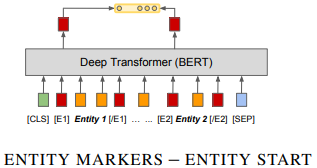

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
  return prepare_data(data, tokenizer, batch_size, True)

train_sequences_mtb = prepare_data_MTB(train, tokenizer)
test_sequences_mtb = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
      super(MTB, self).__init__()

      config = AutoConfig.from_pretrained(base_model_name)
      config.num_labels = 10
      self.model = AutoModel.from_config(config)
      #for param in self.model.parameters():
      #  param.requires_grad = False
      # TODO - your code...   
      self.model.resize_token_embeddings(len(tokenizer))
      self.hidden_size = config.hidden_size 
      self.linear = nn.Linear(self.hidden_size * 2, 10)

    def forward(self, input, attention_mask, index):
      # TODO - your code...
      bert_outputs = self.model(input, attention_mask=attention_mask, output_hidden_states=True)
      hidden_state = bert_outputs.hidden_states[-1]

      e1_indices = index[:,0].unsqueeze(-1)
      e2_indices = index[:,1].unsqueeze(-1)

      e1_indices_to_gather = (e1_indices.repeat(1, self.hidden_size)).unsqueeze(1)
      e2_indices_to_gather = (e2_indices.repeat(1, self.hidden_size)).unsqueeze(1)

      e1_hidden_state = torch.gather(hidden_state, 1, e1_indices_to_gather).squeeze(1)
      e2_hidden_state = torch.gather(hidden_state, 1, e2_indices_to_gather).squeeze(1)
      
      concat_hidden_state = torch.cat((e1_hidden_state, e2_hidden_state), dim=1).to(device)

      return self.linear(concat_hidden_state)   

model_mtb = MTB('bert-base-uncased').to(device)

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
# train the model
optimizer_mtb = torch.optim.Adam(get_parameters(list(model_mtb.named_parameters())[-2:]), lr=0.0001)
train_loop(model_mtb, 25, train_sequences_mtb, None, optimizer_mtb, is_MTB=True)

Starting epoch 1 out of 25
Finished epoch 1 out of 25, cur loss : 2.062089681625366
Starting epoch 2 out of 25
Finished epoch 2 out of 25, cur loss : 2.044422149658203
Starting epoch 3 out of 25
Finished epoch 3 out of 25, cur loss : 2.0689241886138916
Starting epoch 4 out of 25
Finished epoch 4 out of 25, cur loss : 2.14143705368042
Starting epoch 5 out of 25
Finished epoch 5 out of 25, cur loss : 1.8736777305603027
Starting epoch 6 out of 25
Finished epoch 6 out of 25, cur loss : 1.9518063068389893
Starting epoch 7 out of 25
Finished epoch 7 out of 25, cur loss : 2.1712591648101807
Starting epoch 8 out of 25
Finished epoch 8 out of 25, cur loss : 2.0797901153564453
Starting epoch 9 out of 25
Finished epoch 9 out of 25, cur loss : 2.086885690689087
Starting epoch 10 out of 25
Finished epoch 10 out of 25, cur loss : 2.3433666229248047
Starting epoch 11 out of 25
Finished epoch 11 out of 25, cur loss : 2.115905523300171
Starting epoch 12 out of 25
Finished epoch 12 out of 25, cur loss :

In [ ]:
eval_and_format_table(model_mtb, test_sequences_mtb, is_MTB=True)

╒════════════════════╤══════════════════════╤═════════════════════╕
│ Label              │ Recall               │ Precision           │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Entity-Destination │ 0.010273972602739725 │ 0.75                │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Product-Producer   │ 0.004329004329004329 │ 0.16666666666666666 │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Other              │ 0.8986784140969163   │ 0.168944099378882   │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Member-Collection  │ 0.0                  │ 0                   │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Entity-Origin      │ 0.06201550387596899  │ 0.4                 │
├────────────────────┼──────────────────────┼─────────────────────┤
│ Instrument-Agency  │ 0.05128205128205128  │ 0.38095238095238093 │
├────────────────────┼──────────────────────┼───

**Good luck!**